In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import stats
from sklearn.model_selection import train_test_split
from pathlib import Path
import collections

# --- 0. Parámetros Configurables ---
N_ROIS = 1000
TARGET_LEN = 140  # Longitud objetivo para las series temporales (cortar a esta longitud)

# Rutas a tus archivos (AJUSTA ESTAS RUTAS SI ES NECESARIO)
subject_csv_path = '/home/diego/Escritorio/Schaefer_1000/DataBaseSubjects.csv'
# Asumo que el DataFrame 'merged' que usaste antes se puede reconstruir o que DataBaseSubjects.csv
# contiene 'SubjectID' y 'ResearchGroup'. Si 'merged.csv' es el archivo final con esa info, úsalo.
# Por simplicidad, usaré DataBaseSubjects.csv y asumiré que tiene 'ResearchGroup'.
# Si 'ResearchGroup' solo está en 'merged_df', necesitarás cargar ese CSV.
# Vamos a asumir que podemos cargar 'merged_df' directamente si lo guardaste.
# Si no, lo reconstruimos parcialmente.

roi_signals_dir_path = Path('/home/diego/Escritorio/Schaefer_1000/ROISignals')
roi_filename_template = 'ROISignals_{subject_id}.mat'

# Proporciones para la división de datos (para AD y CN)
# El (1 - CLASSIFIER_TRAIN_VAL_RATIO) se usará para el test ciego del clasificador.
# El resto de AD/CN, más todos los "Otros", irán al VAE.
# Y ese mismo "resto de AD/CN" se usará para entrenar/validar el clasificador.
CLASSIFIER_HOLDOUT_TEST_SIZE = 0.20 # 20% de AD/CN para el test ciego del clasificador

# Semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# --- 1. Carga de Metadatos de Sujetos ---
try:
    # Intenta cargar el DataFrame 'merged' si lo guardaste en un CSV.
    # Si no, carga 'DataBaseSubjects.csv' y 'subjects_roi_timepoints_stats.csv' y haz el merge.
    # Por ahora, cargaré 'DataBaseSubjects.csv' y asumiré que 'ResearchGroup' está ahí.
    # Si 'ResearchGroup' está en otro archivo, necesitarás hacer el merge como en tu notebook.
    
    # Opción 1: Cargar un 'merged_df.csv' si existe y tiene SubjectID y ResearchGroup
    # merged_df = pd.read_csv('/ruta/a/tu/merged_df.csv')
    # merged_df['SubjectID'] = merged_df['SubjectID'].astype(str).str.strip()

    # Opción 2: Recrear 'merged_df' (simplificado, asegúrate que tenga 'ResearchGroup')
    stats_df = pd.read_csv('/home/diego/Escritorio/Schaefer_1000/subjects_roi_timepoints_stats.csv')
    subjects_db_df = pd.read_csv('/home/diego/Escritorio/Schaefer_1000/DataBaseSubjects.csv')
    stats_df['SubjectID'] = stats_df['SubjectID'].astype(str).str.strip()
    subjects_db_df['SubjectID'] = subjects_db_df['SubjectID'].astype(str).str.strip()
    merged_df = pd.merge(stats_df, subjects_db_df, on='SubjectID', how='inner')
    # Asegúrate de que la columna de grupo se llame 'ResearchGroup'
    if 'ResearchGroup' not in merged_df.columns:
        raise ValueError("La columna 'ResearchGroup' no se encuentra en el DataFrame merged_df.")
    
    print(f"DataFrame 'merged_df' cargado con shape: {merged_df.shape}")
    print(f"Columnas disponibles: {merged_df.columns.tolist()}")
    print(f"Valores únicos en 'ResearchGroup': {merged_df['ResearchGroup'].unique()}")

except FileNotFoundError as e:
    print(f"Error al cargar archivos CSV: {e}")
    print("Por favor, asegúrate de que las rutas a 'DataBaseSubjects.csv' y 'subjects_roi_timepoints_stats.csv' son correctas y existen.")
    exit()
except ValueError as e:
    print(f"Error con las columnas del DataFrame: {e}")
    exit()


# --- 2. Funciones de Carga y Preprocesamiento de Series Temporales ---
def load_and_preprocess_subject_series(subject_id, target_len):
    """
    Carga, normaliza (Z-score) y homogeneiza la longitud de las series temporales
    de un sujeto.
    Las señales se esperan en formato (Timepoints, ROIs).
    """
    mat_path = roi_signals_dir_path / roi_filename_template.format(subject_id=subject_id)
    if not mat_path.exists():
        # print(f'[WARN] Archivo no encontrado: {mat_path} para sujeto {subject_id}')
        return None, -1

    try:
        data = sio.loadmat(mat_path)
        # Claves comunes para las señales en los archivos .mat
        possible_keys = ["ROISignals", "signals", "roi_signals", "ROIsignals"]
        loaded_sigs = None
        for key in possible_keys:
            if key in data:
                loaded_sigs = data[key]
                break
        
        if loaded_sigs is None:
            # print(f'[WARN] No se encontraron señales en: {mat_path} para sujeto {subject_id} con claves {list(data.keys())}')
            return None, -1
            
        sigs = np.asarray(loaded_sigs) # Formato esperado: (Timepoints, ROIs)
        
        # Validaciones de forma (similar a tu script)
        if sigs.ndim != 2 or sigs.shape[1] != N_ROIS:
            # print(f'[WARN] {mat_path} sujeto {subject_id} tiene shape inesperado: {sigs.shape} (esperado [T, {N_ROIS}])')
            return None, sigs.shape[0] if sigs.ndim > 0 else -1
        
        original_length = sigs.shape[0]
        if original_length < 5: # Muy pocos timepoints
            # print(f'[WARN] {mat_path} sujeto {subject_id} tiene muy pocos timepoints: {original_length}')
            return None, original_length

        # 1. Estandarización (Z-score) por ROI (a lo largo del eje de tiempo, axis=0)
        sigs_normalized = stats.zscore(sigs, axis=0, nan_policy='propagate')
        
        # Manejo de NaNs después de zscore (si una ROI era constante, su std es 0, resultando en NaN o Inf)
        if np.isnan(sigs_normalized).any():
            # print(f'[INFO] Sujeto {subject_id} tiene NaNs después de z-score. Reemplazando NaNs con 0.')
            sigs_normalized = np.nan_to_num(sigs_normalized, nan=0.0, posinf=0.0, neginf=0.0) # Reemplaza NaN e Inf con 0

        # 2. Homogeneización de longitud (cortar)
        if original_length < target_len:
            # print(f'[WARN] Sujeto {subject_id} tiene longitud original {original_length} < target_len {target_len}. Se descarta.')
            # Alternativamente, podrías aplicar padding aquí si esa fuera la estrategia.
            return None, original_length
        
        # Cortar las series temporales al target_len
        # Si sigs_normalized es (Timepoints, ROIs), cortamos en el primer eje
        sigs_homogenized = sigs_normalized[:target_len, :]
        
        return sigs_homogenized, original_length

    except Exception as e:
        print(f'[ERROR] Procesando {mat_path} para sujeto {subject_id} - {str(e)}')
        return None, -1

# --- 3. Procesamiento de Todos los Sujetos ---
all_subjects_data = []
min_len_found_overall = float('inf')
processed_subject_ids = set()

print(f"\nProcesando series temporales para {len(merged_df['SubjectID'].unique())} sujetos...")
for index, row in merged_df.iterrows():
    subject_id = row['SubjectID']
    label = row['ResearchGroup'] # Esta es la etiqueta original (AD, CN, EMCI, LMCI, MCI)

    if subject_id in processed_subject_ids: # Evitar procesar duplicados si los hubiera en merged_df
        continue

    series_data, original_len = load_and_preprocess_subject_series(subject_id, TARGET_LEN)
    
    if series_data is not None:
        all_subjects_data.append({
            "id": subject_id,
            "time_series": series_data, # (TARGET_LEN, N_ROIS)
            "label_original": label, # AD, CN, EMCI, LMCI, MCI
            "original_length": original_len,
            "final_length": series_data.shape[0]
        })
        min_len_found_overall = min(min_len_found_overall, original_len)
        processed_subject_ids.add(subject_id)
    else:
        print(f"Sujeto {subject_id} no pudo ser procesado o fue descartado.")

    if len(processed_subject_ids) % 50 == 0 and len(processed_subject_ids) > 0:
        print(f"  Procesados {len(processed_subject_ids)} sujetos...")

print(f"\nProcesamiento de series temporales completado.")
print(f"Total de sujetos procesados exitosamente y con longitud >= {TARGET_LEN}: {len(all_subjects_data)}")
if all_subjects_data:
    print(f"Forma de series temporales para el primer sujeto procesado: {all_subjects_data[0]['time_series'].shape}")
    print(f"Longitud mínima original encontrada entre los procesados válidos: {min_len_found_overall if min_len_found_overall != float('inf') else 'N/A'}")
else:
    print("No se procesó ningún sujeto exitosamente. Verifica las rutas y los archivos .mat.")
    exit()

# --- 4. Mapeo de Etiquetas y Definición de Cohortes ---
# Mapear etiquetas originales a "AD", "CN", "Otros"
def map_label(original_label):
    if original_label == "AD":
        return "AD"
    elif original_label == "CN":
        return "CN"
    elif original_label in ["EMCI", "LMCI", "MCI"]:
        return "Otros"
    else:
        # print(f"Etiqueta desconocida: {original_label}. Se tratará como 'Otros_Desconocido'.")
        return "Otros_Desconocido" # O manejar como error

for subject in all_subjects_data:
    subject['label_mapped'] = map_label(subject['label_original'])

# Separar por las etiquetas mapeadas
subjects_ad = [s for s in all_subjects_data if s['label_mapped'] == "AD"]
subjects_cn = [s for s in all_subjects_data if s['label_mapped'] == "CN"]
subjects_others = [s for s in all_subjects_data if s['label_mapped'] == "Otros"]

print(f"\nDistribución de sujetos después del mapeo de etiquetas:")
print(f"  Sujetos AD: {len(subjects_ad)}")
print(f"  Sujetos CN: {len(subjects_cn)}")
print(f"  Sujetos Otros (EMCI, LMCI, MCI): {len(subjects_others)}")
unknown_labels = [s for s in all_subjects_data if s['label_mapped'] == "Otros_Desconocido"]
if unknown_labels:
    print(f"  Sujetos con etiquetas desconocidas: {len(unknown_labels)}")

# --- 5. División de Datos ---
# El objetivo es tener:
# 1. vae_train_subjects: AD_vae, CN_vae, Todos_Otros
# 2. classifier_train_val_subjects: AD_clf_tv, CN_clf_tv (estos son los mismos que AD_vae, CN_vae)
# 3. classifier_test_subjects: AD_clf_test, CN_clf_test (conjunto ciego, no usado por VAE)

if not subjects_ad or not subjects_cn:
    print("No hay suficientes sujetos AD o CN para realizar la división. Abortando.")
    exit()

# Dividir AD en (AD para VAE/Clasificador_TrainVal) y (AD para Clasificador_Test)
ad_for_vae_and_clf_tv, ad_clf_test = train_test_split(
    subjects_ad,
    test_size=CLASSIFIER_HOLDOUT_TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=[s['label_original'] for s in subjects_ad] # Estratificar por etiqueta original si hay subtipos de AD
) if len(subjects_ad) > 1 else (subjects_ad, [])


# Dividir CN en (CN para VAE/Clasificador_TrainVal) y (CN para Clasificador_Test)
cn_for_vae_and_clf_tv, cn_clf_test = train_test_split(
    subjects_cn,
    test_size=CLASSIFIER_HOLDOUT_TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=[s['label_original'] for s in subjects_cn] # Estratificar por etiqueta original
) if len(subjects_cn) > 1 else (subjects_cn, [])


# 1. Conjunto de entrenamiento para el VAE
vae_train_subjects = ad_for_vae_and_clf_tv + cn_for_vae_and_clf_tv + subjects_others

# 2. Conjunto de entrenamiento/validación para el Clasificador (subconjunto de lo que vio el VAE)
classifier_train_val_subjects = ad_for_vae_and_clf_tv + cn_for_vae_and_clf_tv

# 3. Conjunto de testeo ciego para el Clasificador
classifier_test_subjects = ad_clf_test + cn_clf_test


# --- 6. Verificación de la División y Estructura Final ---
print(f"\n--- Resumen de la División de Datos ---")

print(f"Total de sujetos para entrenamiento del VAE: {len(vae_train_subjects)}")
if vae_train_subjects:
    counts_vae = collections.Counter(s['label_mapped'] for s in vae_train_subjects)
    print(f"  Composición (mapeada): {counts_vae}")
    # Extraer solo las series temporales para el VAE
    # Forma esperada: (N_sujetos_vae, TARGET_LEN, N_ROIS)
    vae_train_data_X = np.array([s['time_series'] for s in vae_train_subjects])
    vae_train_data_labels_mapped = np.array([s['label_mapped'] for s in vae_train_subjects])
    vae_train_data_labels_original = np.array([s['label_original'] for s in vae_train_subjects])
    print(f"  Forma de datos para VAE (X): {vae_train_data_X.shape if vae_train_data_X.size > 0 else 'Vacío'}")

print(f"\nTotal de sujetos para entrenamiento/validación del Clasificador: {len(classifier_train_val_subjects)}")
if classifier_train_val_subjects:
    counts_clf_train_val = collections.Counter(s['label_mapped'] for s in classifier_train_val_subjects)
    print(f"  Composición (mapeada): {counts_clf_train_val}")
    # Forma esperada: (N_sujetos_clf_tv, TARGET_LEN, N_ROIS)
    classifier_train_val_data_X = np.array([s['time_series'] for s in classifier_train_val_subjects])
    # Para el clasificador, las etiquetas serán binarias (AD vs CN) o mapeadas a números.
    # Por ahora, guardamos las etiquetas mapeadas.
    classifier_train_val_data_y = np.array([s['label_mapped'] for s in classifier_train_val_subjects])
    print(f"  Forma de datos para Clasificador Train/Val (X): {classifier_train_val_data_X.shape if classifier_train_val_data_X.size > 0 else 'Vacío'}")

print(f"\nTotal de sujetos para Test Ciego del Clasificador: {len(classifier_test_subjects)}")
if classifier_test_subjects:
    counts_clf_test = collections.Counter(s['label_mapped'] for s in classifier_test_subjects)
    print(f"  Composición (mapeada): {counts_clf_test}")
    # Forma esperada: (N_sujetos_clf_test, TARGET_LEN, N_ROIS)
    classifier_test_data_X = np.array([s['time_series'] for s in classifier_test_subjects])
    classifier_test_data_y = np.array([s['label_mapped'] for s in classifier_test_subjects])
    print(f"  Forma de datos para Clasificador Test Ciego (X): {classifier_test_data_X.shape if classifier_test_data_X.size > 0 else 'Vacío'}")

print("\n--- Ejemplo de un sujeto procesado (del conjunto VAE) ---")
if vae_train_subjects:
    example_subject = vae_train_subjects[0]
    print(f"ID: {example_subject['id']}")
    print(f"Label Original: {example_subject['label_original']}")
    print(f"Label Mapeada: {example_subject['label_mapped']}")
    print(f"Original length: {example_subject['original_length']}")
    print(f"Final length (homogeneizada): {example_subject['final_length']}")
    print(f"Time series data shape: {example_subject['time_series'].shape}") # Debería ser (TARGET_LEN, N_ROIS)
    # print(f"Time series data (primeros 5 puntos del primer ROI): {example_subject['time_series'][:5, 0]}")
else:
    print("No hay sujetos en el conjunto de entrenamiento del VAE para mostrar un ejemplo.")

print("\nScript finalizado.")
print("Revisa las salidas, especialmente las formas de los arrays y la composición de los conjuntos.")
print(f"Los datos de series temporales (ej. vae_train_data_X) están listos con forma (N_sujetos, {TARGET_LEN}, {N_ROIS}).")

# Próximos pasos:
# 1. Guardar estos arrays (vae_train_data_X, classifier_train_val_data_X, etc.) y las listas de sujetos/etiquetas.
#    Puedes usar np.savez o pandas para guardar los datos y etiquetas.
#    Por ejemplo:
np.savez('vae_train_data.npz', X=vae_train_data_X, y=vae_train_data_labels_mapped)
# 1. Guardar arrays multidimensionales (3D) con numpy
np.save('vae_train_data_X.npy', vae_train_data_X)  # (N_sujetos_vae, 140, 1000)
np.save('classifier_train_val_data_X.npy', classifier_train_val_data_X)  # (N_sujetos_clf_tv, 140, 1000)
np.save('classifier_test_data_X.npy', classifier_test_data_X)  # (N_sujetos_clf_test, 140, 1000)
# 2. Guardar el DataFrame merged_df si es necesario para futuras referencias.
# 3. Guardar los sujetos y etiquetas en archivos CSV si es necesario.
#    Por ejemplo:
np.savetxt('vae_train_data_labels_mapped.csv', vae_train_data_labels_mapped, fmt='%s')
np.savetxt('classifier_train_val_data_y.csv', classifier_train_val_data_y, fmt='%s')
np.savetxt('classifier_test_data_y.csv', classifier_test_data_y, fmt='%s')
# 5. Guardar la longitud mínima encontrada si es necesario.
#    Por ejemplo:
# 3. Guardar los metadatos/tablas de sujetos como DataFrame (opcional, para trazabilidad)
pd.DataFrame(vae_train_subjects).to_csv('vae_train_subjects.csv', index=False)
pd.DataFrame(classifier_train_val_subjects).to_csv('classifier_train_val_subjects.csv', index=False)
pd.DataFrame(classifier_test_subjects).to_csv('classifier_test_subjects.csv', index=False)

# 4. Guardar merged_df si lo necesitás para trazabilidad o referencia
merged_df.to_csv('merged_df.csv', index=False)

# 5. Guardar la longitud mínima encontrada si te sirve para documentación
with open('min_length_found.txt', 'w') as f:
    f.write(f"Longitud mínima encontrada: {min_len_found_overall}\n")

# Ya después del split, justo antes de guardar los arrays:
vae_train_subject_ids = np.array([s['id'] for s in vae_train_subjects])
np.save('vae_train_subject_ids.npy', vae_train_subject_ids)

# Guardar también para los conjuntos de clasificador si querés:
classifier_train_val_subject_ids = np.array([s['id'] for s in classifier_train_val_subjects])
np.save('classifier_train_val_subject_ids.npy', classifier_train_val_subject_ids)
classifier_test_subject_ids = np.array([s['id'] for s in classifier_test_subjects])
np.save('classifier_test_subject_ids.npy', classifier_test_subject_ids)



print("¡Arrays y metadatos guardados correctamente!")


# 2. Proceder a calcular las diferentes matrices de conectividad (Pearson, MI, dFC)
#    USANDO ESTAS SERIES TEMPORALES YA HOMOGENEIZADAS Y NORMALIZADAS.
#    Por ejemplo, para cada sujeto en vae_train_data_X, tomar su serie temporal
#    de (TARGET_LEN, N_ROIS) y calcular su matriz de conectividad.



DataFrame 'merged_df' cargado con shape: (352, 31)
Columnas disponibles: ['SubjectID', 'N_timepoints', 'Signal_mean', 'Signal_std', 'ROI_means_mean', 'ROI_stds_mean', 'Min_signal', 'Max_signal', 'Phase', 'Sex', 'ResearchGroup', 'Visit', 'ArchiveDate', 'StudyDate', 'Age', 'Modality', 'Description', 'ImagingProtocol', 'ImageID', 'PTEDUCAT', 'CDRSB', 'MMSE', 'DIGITSCOR', 'MOCA', 'Ventricles', 'Hippocampus', 'WholeBrain', 'MidTemp', 'ABETA', 'TAU', 'PTAU']
Valores únicos en 'ResearchGroup': ['CN' 'MCI' 'LMCI' 'AD' 'EMCI']

Procesando series temporales para 352 sujetos...
  Procesados 50 sujetos...
  Procesados 100 sujetos...
  Procesados 150 sujetos...
  Procesados 200 sujetos...
  Procesados 250 sujetos...
  Procesados 300 sujetos...
  Procesados 350 sujetos...

Procesamiento de series temporales completado.
Total de sujetos procesados exitosamente y con longitud >= 140: 352
Forma de series temporales para el primer sujeto procesado: (140, 1000)
Longitud mínima original encontrada entre l

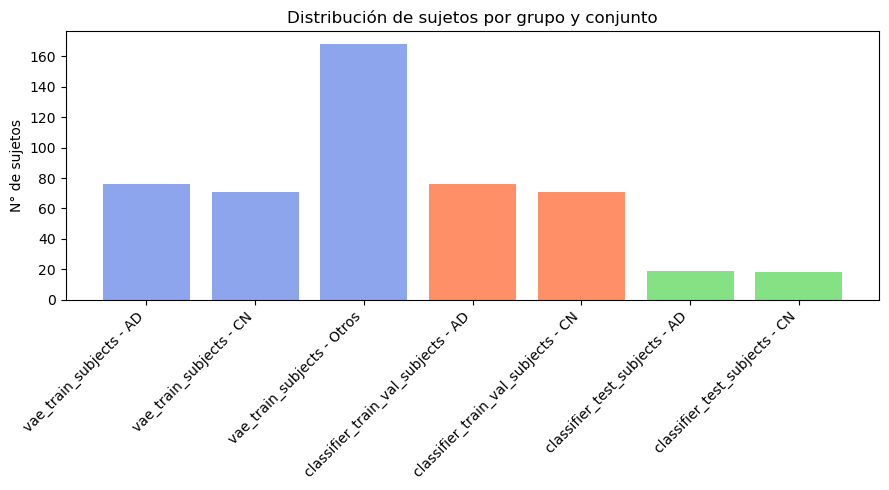

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Recuento de sujetos por grupo en cada conjunto
labels = ['vae_train_subjects', 'classifier_train_val_subjects', 'classifier_test_subjects']
cohorts = [vae_train_subjects, classifier_train_val_subjects, classifier_test_subjects]
colors = ['royalblue', 'orangered', 'limegreen']

plt.figure(figsize=(9, 5))
for i, cohort in enumerate(cohorts):
    counts = collections.Counter([s['label_mapped'] for s in cohort])
    plt.bar([f"{labels[i]} - {k}" for k in counts.keys()], counts.values(), color=colors[i], alpha=0.6)

plt.title("Distribución de sujetos por grupo y conjunto")
plt.ylabel("N° de sujetos")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


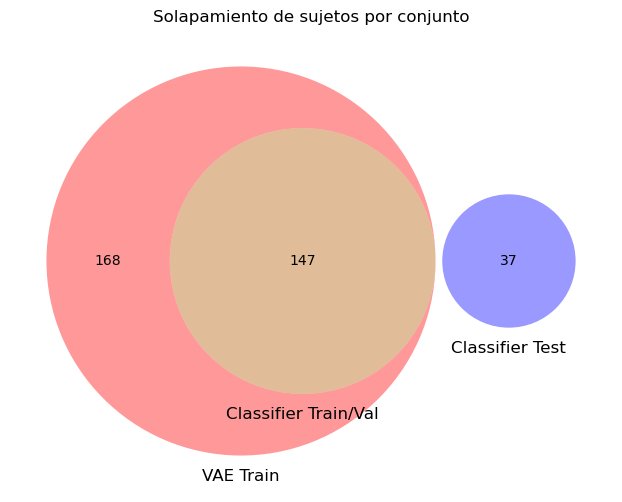

In [6]:
from matplotlib_venn import venn3

ids_vae = set([s['id'] for s in vae_train_subjects])
ids_clf_tv = set([s['id'] for s in classifier_train_val_subjects])
ids_clf_test = set([s['id'] for s in classifier_test_subjects])

plt.figure(figsize=(8,6))
venn3([ids_vae, ids_clf_tv, ids_clf_test],
      set_labels = ('VAE Train', 'Classifier Train/Val', 'Classifier Test'))
plt.title("Solapamiento de sujetos por conjunto")
plt.show()


In [7]:
# Crear DataFrame de asignación de cohortes
all_ids = set(ids_vae) | set(ids_clf_tv) | set(ids_clf_test)
asignacion_df = pd.DataFrame({
    'SubjectID': list(all_ids),
    'in_vae_train': [sid in ids_vae for sid in all_ids],
    'in_clf_train_val': [sid in ids_clf_tv for sid in all_ids],
    'in_clf_test': [sid in ids_clf_test for sid in all_ids],
})

print(asignacion_df.head())
# Guardar para revisar
asignacion_df.to_csv("cohort_assignment_summary.csv", index=False)


    SubjectID  in_vae_train  in_clf_train_val  in_clf_test
0  131_S_6616          True             False        False
1  006_S_6234         False             False         True
2  130_S_6372          True              True        False
3  035_S_7000          True             False        False
4  035_S_7105          True             False        False


/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


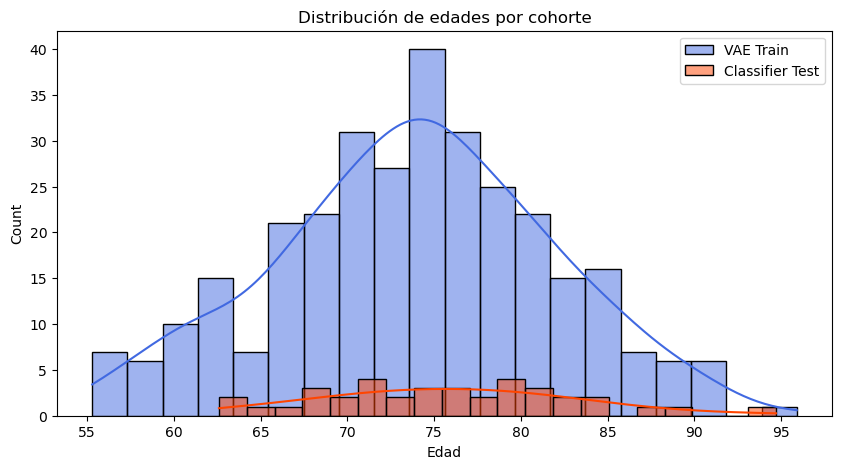

/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/diego/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


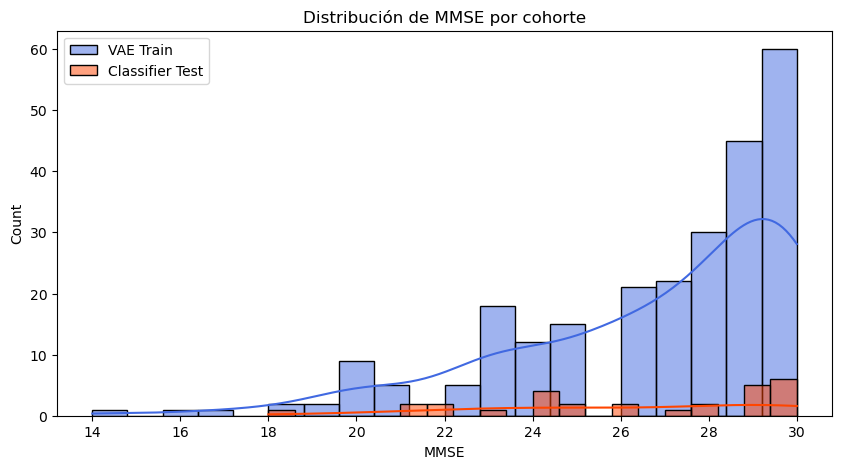

In [8]:
# Unir información de cohortes al merged_df para análisis de variables
merged_df['in_vae_train'] = merged_df['SubjectID'].isin(ids_vae)
merged_df['in_clf_train_val'] = merged_df['SubjectID'].isin(ids_clf_tv)
merged_df['in_clf_test'] = merged_df['SubjectID'].isin(ids_clf_test)

# Ejemplo: distribución de edad
plt.figure(figsize=(10,5))
sns.histplot(data=merged_df[merged_df['in_vae_train']], x='Age', color='royalblue', label='VAE Train', kde=True, bins=20)
sns.histplot(data=merged_df[merged_df['in_clf_test']], x='Age', color='orangered', label='Classifier Test', kde=True, bins=20)
plt.legend()
plt.title("Distribución de edades por cohorte")
plt.xlabel("Edad")
plt.show()

# Ejemplo: distribución de MMSE si está disponible
if 'MMSE' in merged_df.columns:
    plt.figure(figsize=(10,5))
    sns.histplot(data=merged_df[merged_df['in_vae_train']], x='MMSE', color='royalblue', label='VAE Train', kde=True, bins=20)
    sns.histplot(data=merged_df[merged_df['in_clf_test']], x='MMSE', color='orangered', label='Classifier Test', kde=True, bins=20)
    plt.legend()
    plt.title("Distribución de MMSE por cohorte")
    plt.xlabel("MMSE")
    plt.show()


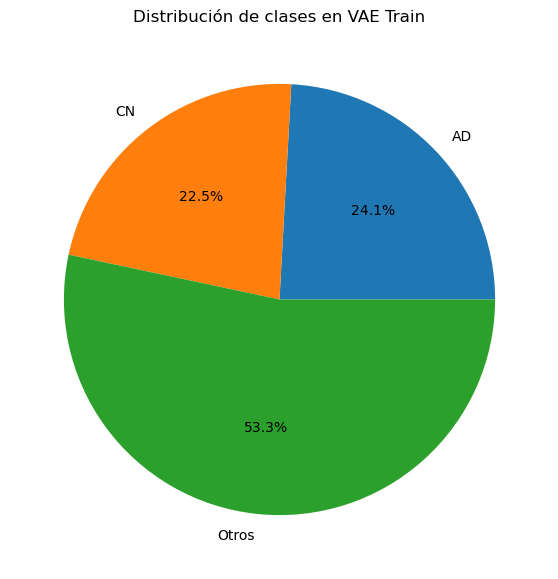

In [9]:
plt.figure(figsize=(7, 7))
counts = collections.Counter([s['label_mapped'] for s in vae_train_subjects])
plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%')
plt.title("Distribución de clases en VAE Train")
plt.show()
